## Model Stock tutorial 
- This Jupyter notebook demonstrates the process of conducting a post-hoc Model Stock. 

### Setup 
- Install requirements 

In [1]:
import torch
import numpy as np
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

### Download Pre-trained and Fine-tuned Weights
- Downliad link: [link](https://www.dropbox.com/scl/fo/shyzn327ge206n3fimomd/AKY_mVAN_kFiR2ejpAGPHQ8?rlkey=qk76yc6jisv8fjf2zdtrw4ki6&st=m43urvv3&dl=0)
- Download pre-trained model weight: `clip_vit_b_32_pretrained.pt`
- Download two fine-tuned model weights: `clip_vit_b_32_finetuned_1.pt`, `clip_vit_b_32_finetuned_2.pt` 


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# load weights
pretrained_weight = '../models/clip_vit_b_32_pretrained.pt'
finetuned_weight_1 = '../models/clip_vit_b_32_finetuned_1.pt'
finetuned_weight_2 = '../models/clip_vit_b_32_finetuned_2.pt'

weight_pt = torch.load(pretrained_weight, map_location=device)
weight_ft1 = torch.load(finetuned_weight_1, map_location=device)
weight_ft2 = torch.load(finetuned_weight_2, map_location=device)

### Compute Angle and Interpolation Ratio 

In [6]:
import math 
from collections import OrderedDict
from math import sqrt
EPS = 1e-8

def compute_angle(state_dict_1, state_dict_2, ref_state_dict, add_ignore_keys=[], return_cos=False):
    # Remove the keys not used for CLIP fine-tuning
    ignore_keys = ['model.positional_embedding', 'model.text_projection', 'model.logit_scale',
                        'model.token_embedding.weight', 'model.ln_final.weight', 'model.ln_final.bias']
    ignore_keys += ['module.'+key for key in ignore_keys]
    ignore_keys.extend(add_ignore_keys)

    return_dict = OrderedDict()

    with torch.no_grad():
        for key in ref_state_dict:
            if key in ignore_keys:
                continue

            state_dict_1_val = state_dict_1[key]            
            state_dict_2_val = state_dict_2[key]                        
            ref_val = ref_state_dict[key]

            if not (state_dict_1_val.shape == state_dict_2_val.shape == ref_val.shape):
                continue 

            vector1 = (state_dict_1_val - ref_val).clone().detach()
            vector2 = (state_dict_2_val - ref_val).clone().detach()

            vector1 = vector1.float()
            vector2 = vector2.float()

            cosine_val = torch.sum(vector1 * vector2) / (sqrt(torch.sum(vector1 ** 2) * torch.sum(vector2 ** 2))+EPS)
            cosine_val = torch.clamp(cosine_val, min=-1., max=1.) # Too prevent nan from acos
            if return_cos:
                return_dict[key] = cosine_val 
            else:
                return_dict[key] = np.rad2deg(torch.acos(cosine_val).detach().cpu())

    return return_dict

def compute_ratio(angle_dict, k=2):
    ratio_dict = {}
    for key in angle_dict.keys():
        angle = np.deg2rad(angle_dict[key])
        ratio_dict[key] = k*np.cos(angle)/((k-1)*np.cos(angle)+1+EPS)
    return ratio_dict 


In [7]:
# Compute angles
angle = compute_angle(weight_ft1, weight_ft2, weight_pt)
ratio = compute_ratio(angle)
print(angle.keys())


odict_keys(['model.visual.class_embedding', 'model.visual.positional_embedding', 'model.visual.proj', 'model.visual.conv1.weight', 'model.visual.ln_pre.weight', 'model.visual.ln_pre.bias', 'model.visual.transformer.resblocks.0.attn.in_proj_weight', 'model.visual.transformer.resblocks.0.attn.in_proj_bias', 'model.visual.transformer.resblocks.0.attn.out_proj.weight', 'model.visual.transformer.resblocks.0.attn.out_proj.bias', 'model.visual.transformer.resblocks.0.ln_1.weight', 'model.visual.transformer.resblocks.0.ln_1.bias', 'model.visual.transformer.resblocks.0.mlp.c_fc.weight', 'model.visual.transformer.resblocks.0.mlp.c_fc.bias', 'model.visual.transformer.resblocks.0.mlp.c_proj.weight', 'model.visual.transformer.resblocks.0.mlp.c_proj.bias', 'model.visual.transformer.resblocks.0.ln_2.weight', 'model.visual.transformer.resblocks.0.ln_2.bias', 'model.visual.transformer.resblocks.1.attn.in_proj_weight', 'model.visual.transformer.resblocks.1.attn.in_proj_bias', 'model.visual.transformer.r

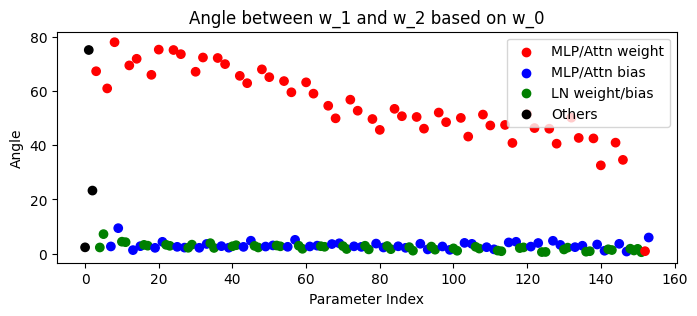

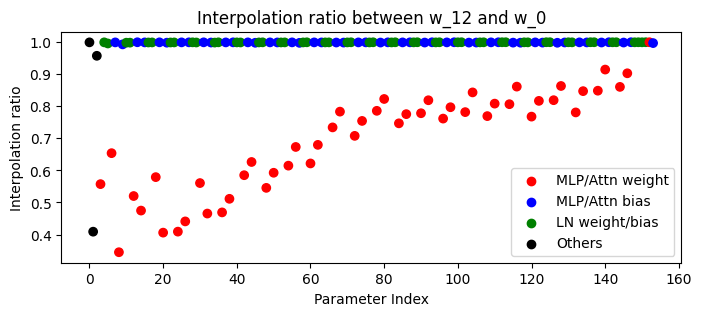

In [9]:
# Visualization 
data = angle.items() 
x = list(range(len(data)))
y = [float(item[1]) for item in data]
colors = ['green' if 'ln' in item[0] else 
          'red' if 'weight' in item[0] else 
          'blue' if 'bias' in item[0] else 
          'black' for item in data]

plt.figure(figsize=(8, 3))
plt.scatter(x, y, c=colors)
plt.xlabel('Parameter Index')
plt.ylabel('Angle')
plt.title('Angle between w_1 and w_2 based on w_0')
# add legend right top
plt.scatter([], [], c='red', label='MLP/Attn weight')
plt.scatter([], [], c='blue', label='MLP/Attn bias')
plt.scatter([], [], c='green', label='LN weight/bias')
plt.scatter([], [], c='black', label='Others')
plt.legend(loc='upper right')
plt.show()

data = ratio.items() 
x = list(range(len(data)))
y = [float(item[1]) for item in data]
plt.figure(figsize=(8, 3))
plt.scatter(x, y, c=colors)
plt.xlabel('Parameter Index')
plt.ylabel('Interpolation ratio')
plt.title('Interpolation ratio between w_12 and w_0')
# add legend right top
plt.scatter([], [], c='red', label='MLP/Attn weight')
plt.scatter([], [], c='blue', label='MLP/Attn bias')
plt.scatter([], [], c='green', label='LN weight/bias')
plt.scatter([], [], c='black', label='Others')
plt.legend(loc='lower right')
plt.show()

### Merge Model Weights 

In [10]:
import copy 
def merge(w1, w2, w0, ratio):
    w12 = {} # w12 = (w1 + w2) / 2
    for key in w1.keys():                
        w12[key] = (w1[key].clone() + w2[key].clone()) / 2.

    w_merge = copy.deepcopy(w12)
    for key, r in ratio.items():        
        w_merge[key] = w12[key].clone() * r + w0[key].clone() * (1. - r)
    return w_merge
    
# Merge weights 
merged_weight = merge(weight_ft1, weight_ft2, weight_pt, ratio)

### Evaluate the Merged Model
- Evaluation is done with [Model Soups](https://github.com/mlfoundations/model-soups) evaluation code.

In [11]:
import sys
sys.path.append('../model-soups')
import clip
base_model, preprocess = clip.load('ViT-B/32', 'cpu', jit=False)

/root/miniconda3/envs/tinyllava/lib/python3.10/site-packages/clip/clip.py:6: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import packaging
100%|███████████████████████████████████████| 338M/338M [01:08<00:00, 5.17MiB/s]


In [10]:
from datasets import ImageNet, ImageNetV2, ImageNetSketch, ImageNetR, ObjectNet, ImageNetA
from utils import get_model_from_sd, test_model_on_dataset

data_location = '/path/to/dataset/'
data_location = '/mnt/tmp/'
batch_size = 256
workers = 4

# reference: https://github.com/mlfoundations/model-soups/blob/main/main.py#L90-L103
model = get_model_from_sd(merged_weight, base_model)
results = {}
for dataset_cls in [ImageNet, ImageNetV2, ImageNetSketch, ImageNetR, ObjectNet, ImageNetA]:
    print(f'Evaluating on {dataset_cls.__name__}.')
    dataset = dataset_cls(preprocess, data_location, batch_size)
    accuracy = test_model_on_dataset(model, dataset)
    results[dataset_cls.__name__] = accuracy
    print(accuracy)
    
print(f'In-distribution (ImageNet): {results["ImageNet"]}')
print(f'Average of out-of-distributions: {np.mean(list(results.values())[1:])}')

Evaluating on ImageNet.
[0% 0/196]	Acc: 88.67	Data (t) 6.055	Batch (t) 19.685
[10% 20/196]	Acc: 82.16	Data (t) 0.013	Batch (t) 0.168
[20% 40/196]	Acc: 81.47	Data (t) 0.020	Batch (t) 0.162
[31% 60/196]	Acc: 81.17	Data (t) 0.013	Batch (t) 0.184
[41% 80/196]	Acc: 81.59	Data (t) 0.013	Batch (t) 0.169
[51% 100/196]	Acc: 80.67	Data (t) 0.013	Batch (t) 0.166
[61% 120/196]	Acc: 80.66	Data (t) 0.013	Batch (t) 0.172
[71% 140/196]	Acc: 80.16	Data (t) 0.015	Batch (t) 0.160
[82% 160/196]	Acc: 79.85	Data (t) 0.013	Batch (t) 0.152
[92% 180/196]	Acc: 79.51	Data (t) 0.013	Batch (t) 0.147
0.79672
Evaluating on ImageNetV2.
[0% 0/40]	Acc: 80.08	Data (t) 4.700	Batch (t) 4.915
[50% 20/40]	Acc: 70.44	Data (t) 0.013	Batch (t) 0.148
0.6922
Evaluating on ImageNetSketch.
[0% 0/199]	Acc: 49.61	Data (t) 7.800	Batch (t) 7.974
[10% 20/199]	Acc: 39.68	Data (t) 0.013	Batch (t) 0.191
[20% 40/199]	Acc: 42.06	Data (t) 0.013	Batch (t) 0.361
[30% 60/199]	Acc: 42.50	Data (t) 0.013	Batch (t) 0.176
[40% 80/199]	Acc: 44.43	Dat